# Instalação dos pacotes

---



In [ ]:
!pip install opencv-python==4.6.0
!sudo apt install tesseract-ocr
!pip install pytesseract==0.3.9

# Download dos dados do Tesseract

---



In [ ]:
!mkdir tessdata

!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

# Instalação do idioma Português

---



In [ ]:
!apt-get install tesseract-ocr-por

# Importação dos pacotes

---



In [5]:
import pytesseract
from pytesseract import Output

import cv2
from google.colab.patches import cv2_imshow
from imutils import contours

import numpy as np
import re

# Função `extrair_dados_imagem`
A função extraí da imagem os caracteres e seus contornos.

---



In [6]:
def extrair_dados_imagem(img, config_tesseract):

  img_copy = img.copy()
  gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY) # convertendo a imagem para a escala cinza
  (aux, black) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) # limiarizando a imagem

  thresh = cv2.threshold(black,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

  # encontando os contornos dos caracteres
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  cnts, _ = contours.sort_contours(cnts, method="top-to-bottom")

  linhas = [] # lista para guardar os caracters extraídos
  contornos = [] # lista para guardar os contornos dos caracters

  # variáveis auxiliares
  texto = []
  box_texto = []
  ROI_number = 0
  y_ant = 0
  min_conf = 0 # usado para filtrar espaços em branco extraídos da imagem

  for c in cnts:

    area = cv2.contourArea(c)

    if area > 1:

        x,y,w,h = cv2.boundingRect(c)

        ROI = 255 - img_copy[y-3:y+h+3, x-3:x+w+3] #area da imagem onde o caracter está

        # processamento para mellhorar a deteccção do caracter
        ROI_afterd = cv2.resize(ROI, (ROI.shape[1]*3, ROI.shape[0]*3), interpolation=cv2.INTER_LANCZOS4)
        gray = cv2.cvtColor(ROI_afterd, cv2.COLOR_BGR2GRAY)
        sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        ROI_sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
        ROI_thresh = cv2.threshold(ROI_sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        #extraí o texto
        osd = pytesseract.image_to_data(ROI_thresh, lang = 'eng', config = config_tesseract, output_type = Output.DICT)

        letra = np.array(osd['text'])
        conf = np.array(osd['conf'])

        letra = list(letra[conf != '-1'])

        if ROI_number == 0:
            y_ant = y
            texto.append(letra[0])
            box_texto.append((x, y, h, w))
        elif y_ant == y:
            texto.append(letra[0])
            box_texto.append((x, y, h, w))
        else:
            y_ant = y
            linhas.append(texto)
            contornos.append(box_texto)

            texto = []
            box_texto = []

            texto.append(letra[0])
            box_texto.append((x, y, h, w))

        ROI_number += 1

  linhas.append(texto)
  contornos.append(box_texto)

  return linhas, contornos

# Função `encontrar_indices`

---


A função busca as palavras dentro da matriz `m` e retorna uma lista contendo o índice da palavra na matriz, um booleano indicando se a palavra está na ordem reversa ou não e a posição inicial e final da palavra dentro do indíce da matriz.

In [12]:
def encontrar_indices(m, invertido, palavras):

  lista = {}
  for e in enumerate(m):

    letras = list(e[1])
    letras = ''.join(letras).lower()

    for palavra in palavras:

      if (palavra in letras):
        match=(re.search(palavra, letras))
        lista[palavra] = [e[0], invertido, match.span()]

      elif(palavra in letras[::-1]):
        match=(re.search(palavra, letras[::-1]))
        lista[palavra] = [e[0], not invertido, match.span()]

  return lista

# Função `encontrar_palavras`


---


Utiliza a função `encontrar_indices` para gerar os dicionários que contêm todas as palavras encontradas na horizontal, vertical ou nas diagonais.

In [13]:
def encontrar_palavras(linhas, palavras):

  horizontal = {}
  vertical = {}
  diagonal_primaria = {}
  diagonal_secundaria = {}

  m = np.row_stack(linhas)

  horizontal = encontrar_indices(m, True, palavras)
  vertical = encontrar_indices(m.T, False, palavras)

  diag1 = [m[::-1,:].diagonal(i) for i in range(-m.shape[0]+1,m.shape[1])]
  diag2 = [m.diagonal(i) for i in range(m.shape[1]-1,-m.shape[0],-1)]

  diagonal_primaria = encontrar_indices(diag1, True, palavras)
  diagonal_secundaria = encontrar_indices(diag2, False, palavras)

  return horizontal, vertical, diagonal_primaria, diagonal_secundaria

# Função `marcar_palavras`


---


Sinaliza na imagem o local das palavras encontradas na horizontal e na vertical.

In [14]:
def marcar_palavras(c, invertido, indices, img, cor = (255, 100, 0)):

  img_final = img.copy()
  n = c.shape[1]

  for k in indices:

    indice = indices[k][0]
    inv = indices[k][1]
    a = indices[k][2][0]
    b = indices[k][2][1]

    if(inv == invertido):
      x = c[indice][a][0]
      y = c[indice][a][1]
      ponto_inicial = ((x, y))

      x = c[indice][b-1][0]
      y = c[indice][b-1][1]
      ponto_final = ((x, y))
    else:
      x = c[indice][n - b][0]
      y = c[indice][n - b][1]
      ponto_inicial = ((x, y))

      x = c[indice][n - a - 1][0]
      y = c[indice][n - a - 1][1]
      ponto_final = ((x, y))

    cv2.rectangle(img_final, (ponto_inicial[0] + 15, ponto_inicial[1]), (ponto_final[0] - 5, ponto_final[1] + 15), cor, 1)
  return img_final

# Função `marcar_palavras_diagonal`


---


Sinaliza na imagem o local das palavras encontradas nas diagonais.

In [15]:
def marcar_palavras_diagonal(d, invertido, indices, img, w1 = 0, w2 = 0, cor = (255, 100, 0)):

  img_final = img.copy()

  for k in indices:

    indice = indices[k][0]
    inv = indices[k][1]
    a = indices[k][2][0]
    b = indices[k][2][1]

    if(inv == invertido):
      x = d[indice][:, a][0]
      y = d[indice][:, a][1]
      ponto_inicial = ((x, y))

      x = d[indice][:, b-1][0]
      y = d[indice][:, b-1][1]
      ponto_final = ((x, y))
    else:
      d_flip = np.flip(d[indice], 1)
      x = d_flip[:, a][0]
      y = d_flip[:, a][1]
      ponto_inicial = ((x, y))

      x = d_flip[:, b-1][0]
      y = d_flip[:, b-1][1]
      ponto_final = ((x, y))

    cv2.line(img_final, (ponto_inicial[0] + w1, ponto_inicial[1]), (ponto_final[0] + w1, ponto_final[1]), (0,255,0), 1)
    cv2.line(img_final, (ponto_inicial[0] + w2, ponto_inicial[1] + 15), (ponto_final[0] + w2, ponto_final[1] + 15), (0,255,0), 1)

  return img_final

# Solucionando o caça-palavras (12 x 12)

---



## Leitura da imagem

In [26]:
config_tesseract = '--tessdata-dir tessdata --psm 10 --oem 2 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ'
img = cv2.imread('/content/img/caca_palavra_05.PNG')

linhas, contornos = extrair_dados_imagem(img, config_tesseract)

In [27]:
print(linhas)

[['O', 'L', 'A', 'R', 'A', 'N', 'J', 'A', 'C', 'R', 'E', 'N'], ['S', 'L', 'N', 'S', 'A', 'H', 'H', 'L', 'A', 'I', 'S', 'D'], ['T', 'D', 'A', 'G', 'E', 'A', 'L', 'N', 'I', 'I', 'O', 'E'], ['S', 'T', 'N', 'U', 'Y', 'O', 'E', 'A', 'D', 'E', 'O', 'W'], ['O', 'A', 'A', 'J', 'O', 'A', 'B', 'A', 'C', 'A', 'T', 'E'], ['M', 'A', 'B', 'A', 'I', 'O', 'G', 'M', 'D', 'C', 'I', 'M'], ['E', 'R', 'R', 'C', 'R', 'E', 'N', 'L', 'A', 'E', 'W', 'O'], ['E', 'R', 'W', 'A', 'L', 'O', 'I', 'V', 'A', 'R', 'G', 'R'], ['S', 'H', 'N', 'S', 'N', 'G', 'M', 'A', 'T', 'O', 'F', 'A'], ['S', 'O', 'E', 'C', 'T', 'I', 'A', 'A', 'Y', 'L', 'W', 'N'], ['E', 'U', 'L', 'V', 'A', 'F', 'A', 'N', 'H', 'A', 'E', 'G'], ['E', 'E', 'G', 'A', 'S', 'E', 'D', 'H', 'H', 'F', 'O', 'O']]


## Buscando as palavras

In [34]:
palavras = ['acerola', 'amora', 'abacate', 'banana', 'caju', 'figo', 'framboesa', 'goiaba',
            'graviola', 'laranja', 'manga', 'morango']

In [35]:
horizontal, vertical, diagonal_primaria, diagonal_secundaria = encontrar_palavras(linhas, palavras)

In [36]:
horizontal

{'laranja': [0, True, (1, 8)],
 'abacate': [4, True, (5, 12)],
 'goiaba': [5, False, (5, 11)],
 'graviola': [7, False, (1, 9)]}

In [37]:
vertical

{'banana': [2, True, (6, 12)],
 'caju': [3, True, (5, 9)],
 'figo': [5, True, (1, 5)],
 'acerola': [9, False, (4, 11)],
 'morango': [11, False, (5, 12)]}

In [38]:
diagonal_primaria

{'manga': [5, True, (0, 5)]}

In [39]:
diagonal_secundaria

{'framboesa': [9, True, (1, 10)], 'amora': [13, True, (2, 7)]}

## Marcandos as palavras encontradas na imagem

In [40]:
c0 = np.stack(contornos, axis=0)
c1 = np.stack(contornos, axis=1)
d1 = [c1[::-1,:].diagonal(i) for i in range(-c1.shape[0]+1,c1.shape[1])]
d2 = [c0.diagonal(i) for i in range(c0.shape[1]-1,-c0.shape[0],-1)]

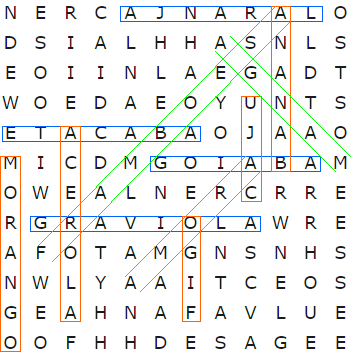

In [41]:
img_marcada = marcar_palavras(c0, True, horizontal, img, (255, 100, 0))
img_marcada = marcar_palavras(c1, False, vertical, img_marcada, (0, 100, 255))
img_marcada = marcar_palavras_diagonal(d1, False, diagonal_primaria, img_marcada, 15, 0, (0, 100, 255))
img_marcada = marcar_palavras_diagonal(d2, False, diagonal_secundaria, img_marcada, 0, 15, (0, 100, 255))

cv2_imshow(img_marcada)

# Solucionando o caça-palavras (18 x 12)

---



## Leitura da imagem

In [ ]:
config_tesseract = '--tessdata-dir tessdata --psm 10 --oem 2 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ'
img = cv2.imread('/content/img/caca_palavra_06.PNG')

linhas, contornos = extrair_dados_imagem(img, config_tesseract)

In [ ]:
print(linhas)

[['E', 'E', 'E', 'S', 'E', 'W', 'A', 'I', 'M', 'D', 'B', 'R', 'P', 'I', 'N', 'O', 'I', 'U', 'G', 'O', 'L', 'E'], ['G', 'A', 'S', 'E', 'U', 'Q', 'R', 'U', 'T', 'O', 'L', 'H', 'R', 'E', 'B', 'R', 'O', 'N', 'Z', 'E', 'P', 'S'], ['R', 'S', 'I', 'D', 'S', 'T', 'L', 'U', 'Z', 'A', 'E', 'H', 'E', 'E', 'M', 'R', 'N', 'H', 'O', 'I', 'A', 'T'], ['S', 'O', 'H', 'H', 'U', 'Y', 'A', 'A', 'A', 'V', 'H', 'I', 'H', 'O', 'E', 'U', 'M', 'O', 'L', 'T', 'V', 'C'], ['S', 'R', 'F', 'N', 'T', 'N', 'R', 'H', 'O', 'T', 'E', 'T', 'A', 'L', 'R', 'A', 'C', 'S', 'E', 'S', 'I', 'A'], ['N', 'A', 'A', 'I', 'H', 'L', 'A', 'A', 'A', 'A', 'O', 'R', 'E', 'S', 'A', 'T', 'S', 'S', 'M', 'T', 'L', 'S'], ['T', 'Y', 'I', 'M', 'O', 'I', 'N', 'E', 'N', 'A', 'C', 'A', 'M', 'D', 'L', 'R', 'F', 'E', 'A', 'R', 'O', 'T'], ['R', 'R', 'S', 'R', 'I', 'E', 'J', 'E', 'M', 'R', 'N', 'A', 'L', 'E', 'R', 'W', 'I', 'U', 'R', 'I', 'S', 'A'], ['W', 'O', 'H', 'A', 'A', 'F', 'A', 'A', 'R', 'O', 'A', 'A', 'E', 'N', 'L', 'E', 'S', 'V', 'A', 'E', 'N

## Buscando as palavras

In [ ]:
palavras = ['alface', 'batata', 'beterraba', 'couve', 'espinafre', 'mandioca', 'maxixe',
            'nabo', 'pimenta', 'pepino', 'rabanete', 'tomate']

In [ ]:
horizontal, vertical, diagonal_primaria, diagonal_secundaria = encontrar_palavras(linhas, palavras)

In [ ]:
horizontal

{'bronze': [1, True, (14, 20)],
 'turquesa': [1, False, (13, 21)],
 'azul': [2, False, (12, 16)],
 'escarlate': [4, False, (3, 12)],
 'preto': [10, True, (12, 17)]}

In [ ]:
vertical

{'indigo': [0, True, (1, 7)],
 'fuchsia': [2, True, (4, 11)],
 'carmin': [3, True, (6, 12)],
 'laranja': [6, False, (2, 9)],
 'branco': [10, True, (5, 11)],
 'caramelo': [18, True, (6, 14)],
 'creme': [19, True, (1, 6)],
 'oliva': [20, True, (9, 14)],
 'castanho': [21, False, (3, 11)]}

In [ ]:
diagonal_primaria

{'amarelo': [15, False, (6, 13)],
 'esmeralda': [19, True, (2, 11)],
 'dourado': [26, False, (4, 11)]}

In [ ]:
diagonal_secundaria

{'verde': [14, True, (5, 10)],
 'vermelho': [15, False, (3, 11)],
 'marrom': [20, True, (3, 9)],
 'violeta': [22, True, (1, 8)],
 'marfim': [24, True, (4, 10)]}

## Marcandos as palavras encontradas na imagem

In [ ]:
c0 = np.stack(contornos, axis=0)
c1 = np.stack(contornos, axis=1)
d1 = [c1[::-1,:].diagonal(i) for i in range(-c1.shape[0]+1,c1.shape[1])]
d2 = [c0.diagonal(i) for i in range(c0.shape[1]-1,-c0.shape[0],-1)]

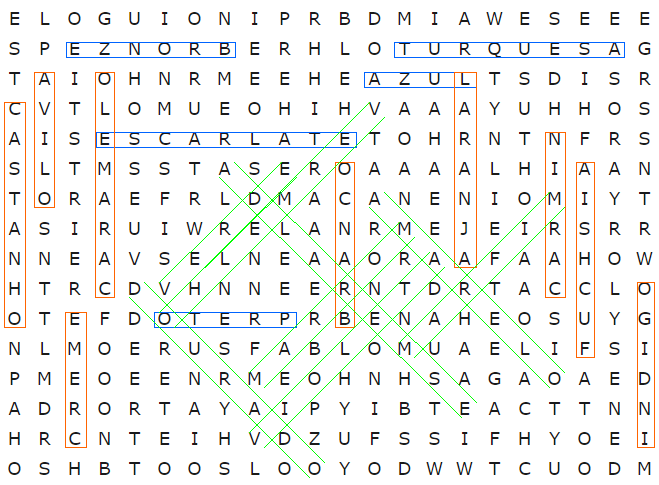

In [ ]:
img_marcada = marcar_palavras(c0, True, horizontal, img, (255, 100, 0))
img_marcada = marcar_palavras(c1, False, vertical, img_marcada, (0, 100, 255))
img_marcada = marcar_palavras_diagonal(d1, False, diagonal_primaria, img_marcada, 15, 0, (0, 100, 255))
img_marcada = marcar_palavras_diagonal(d2, False, diagonal_secundaria, img_marcada, 0, 15, (0, 100, 255))

cv2_imshow(img_marcada)

# Solucionando o caça-palavras (16 x 22)

---



## Leitura da imagem

In [7]:
config_tesseract = '--tessdata-dir tessdata --psm 10 --oem 2 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ'
img = cv2.imread('/content/img/caca_palavra_06.PNG')

linhas, contornos = extrair_dados_imagem(img, config_tesseract)

In [24]:
print(linhas)

[['E', 'E', 'E', 'S', 'E', 'W', 'A', 'I', 'M', 'D', 'B', 'R', 'P', 'I', 'N', 'O', 'I', 'U', 'G', 'O', 'L', 'E'], ['G', 'A', 'S', 'E', 'U', 'Q', 'R', 'U', 'T', 'O', 'L', 'H', 'R', 'E', 'B', 'R', 'O', 'N', 'Z', 'E', 'P', 'S'], ['R', 'S', 'I', 'D', 'S', 'T', 'L', 'U', 'Z', 'A', 'E', 'H', 'E', 'E', 'M', 'R', 'N', 'H', 'O', 'I', 'A', 'T'], ['S', 'O', 'H', 'H', 'U', 'Y', 'A', 'A', 'A', 'V', 'H', 'I', 'H', 'O', 'E', 'U', 'M', 'O', 'L', 'T', 'V', 'C'], ['S', 'R', 'F', 'N', 'T', 'N', 'R', 'H', 'O', 'T', 'E', 'T', 'A', 'L', 'R', 'A', 'C', 'S', 'E', 'S', 'I', 'A'], ['N', 'A', 'A', 'I', 'H', 'L', 'A', 'A', 'A', 'A', 'O', 'R', 'E', 'S', 'A', 'T', 'S', 'S', 'M', 'T', 'L', 'S'], ['T', 'Y', 'I', 'M', 'O', 'I', 'N', 'E', 'N', 'A', 'C', 'A', 'M', 'D', 'L', 'R', 'F', 'E', 'A', 'R', 'O', 'T'], ['R', 'R', 'S', 'R', 'I', 'E', 'J', 'E', 'M', 'R', 'N', 'A', 'L', 'E', 'R', 'W', 'I', 'U', 'R', 'I', 'S', 'A'], ['W', 'O', 'H', 'A', 'A', 'F', 'A', 'A', 'R', 'O', 'A', 'A', 'E', 'N', 'L', 'E', 'S', 'V', 'A', 'E', 'N

## Buscando as palavras

In [10]:
palavras = ['azul', 'amarelo', 'branco', 'bronze', 'caramelo', 'carmin', 'castanho', 'creme', 'dourado', 'esmeralda',
           'escarlate', 'fuchsia', 'indigo', 'laranja', 'marrom', 'marfim', 'oliva', 'preto', 'turquesa', 'vermelho',
           'verde', 'violeta']

In [16]:
horizontal, vertical, diagonal_primaria, diagonal_secundaria = encontrar_palavras(linhas, palavras)

In [17]:
horizontal

{'bronze': [1, True, (14, 20)],
 'turquesa': [1, False, (13, 21)],
 'azul': [2, False, (12, 16)],
 'escarlate': [4, False, (3, 12)],
 'preto': [10, True, (12, 17)]}

In [18]:
vertical

{'indigo': [0, True, (1, 7)],
 'fuchsia': [2, True, (4, 11)],
 'carmin': [3, True, (6, 12)],
 'laranja': [6, False, (2, 9)],
 'branco': [10, True, (5, 11)],
 'caramelo': [18, True, (6, 14)],
 'creme': [19, True, (1, 6)],
 'oliva': [20, True, (9, 14)],
 'castanho': [21, False, (3, 11)]}

In [19]:
diagonal_primaria

{'amarelo': [15, False, (6, 13)],
 'esmeralda': [19, True, (2, 11)],
 'dourado': [26, False, (4, 11)]}

In [20]:
diagonal_secundaria

{'verde': [14, True, (5, 10)],
 'vermelho': [15, False, (3, 11)],
 'marrom': [20, True, (3, 9)],
 'violeta': [22, True, (1, 8)],
 'marfim': [24, True, (4, 10)]}

## Marcandos as palavras encontradas na imagem

In [21]:
c0 = np.stack(contornos, axis=0)
c1 = np.stack(contornos, axis=1)
d1 = [c1[::-1,:].diagonal(i) for i in range(-c1.shape[0]+1,c1.shape[1])]
d2 = [c0.diagonal(i) for i in range(c0.shape[1]-1,-c0.shape[0],-1)]

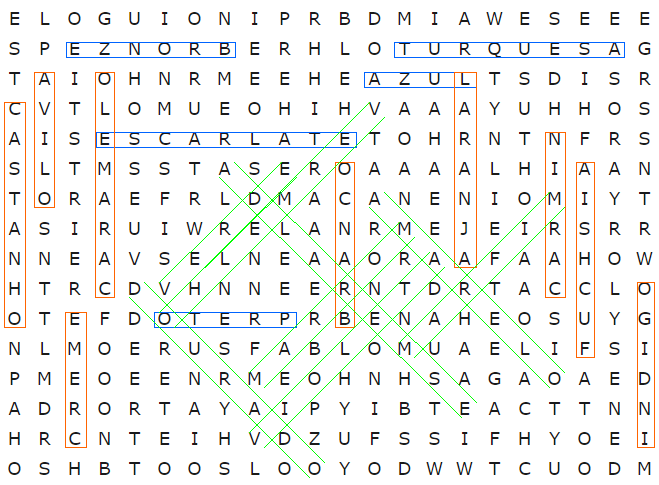

In [22]:
img_marcada = marcar_palavras(c0, True, horizontal, img, (255, 100, 0))
img_marcada = marcar_palavras(c1, False, vertical, img_marcada, (0, 100, 255))
img_marcada = marcar_palavras_diagonal(d1, False, diagonal_primaria, img_marcada, 15, 0, (0, 100, 255))
img_marcada = marcar_palavras_diagonal(d2, False, diagonal_secundaria, img_marcada, 0, 15, (0, 100, 255))

cv2_imshow(img_marcada)